<a href="https://colab.research.google.com/github/Weifeng-Ke/Machine-Learning/blob/main/CPEN455_2024W02_Assignment_2_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/CPEN_455/Assignment_2"

Mounted at /content/drive
/content/drive/MyDrive/CPEN_455/Assignment_2


In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

In [3]:
class SubstringDataset(Dataset):
    LETTERS = list('cpen')

    def __init__(self, seed, dataset_size, str_len=20):
        super().__init__()
        self.str_len = str_len
        self.dataset_size = dataset_size
        self.rng = np.random.default_rng(seed)
        self.strings, self.labels = self._create_dataset()

    def __getitem__(self, index):
        return self.strings[index], self.labels[index]

    def __len__(self):
        return self.dataset_size

    def _create_dataset(self):
        strings, labels = [], []
        for i in range(self.dataset_size):
            label = i%2
            string = self._generate_random_string(bool(label))
            strings.append(string)
            labels.append(label)
        return strings, labels

    def _generate_random_string(self, has_cpen):
        while True:
            st = ''.join(self.rng.choice(SubstringDataset.LETTERS, size=self.str_len))
            if ('cpen' in st) == has_cpen:
                return st

In [4]:
class Tokenizer():
    def __init__(self) -> None:
        self.vocab = {
            '[CLS]': 0,
            'c': 1,
            'p': 2,
            'e': 3,
            'n': 4,
        }

    def tokenize_string(self, string, add_cls_token=True) -> torch.Tensor:
        """
        Tokenize the input string according to the above vocab

        START BLOCK
        """
        tokens=[]
        token_ids=[]

        if add_cls_token:
            tokens.append(self.vocab['[CLS]'])

        #split the string into individual characters
        tokens.extend(list(string))

        #convert each token into corresponding id using the vocab
        for token in tokens:
          if token == 0:
              token_ids.append(0)
          else:
              token_ids.append(self.vocab[token])

        # creat one hot matrix for token ids
        num_tokens=len(token_ids)
        dvoc=len(self.vocab)
        one_hot=torch.zeros(num_tokens,dvoc)

        #convert the list of tokens into one hot
        token_ids_tensor=torch.tensor(token_ids)
        one_hot=F.one_hot(token_ids_tensor,num_classes=dvoc)

        tokenized_string = one_hot
        """
        END BLOCK
        """
        return tokenized_string

    def tokenize_string_batch(self, strings, add_cls_token=True):
        X = []
        for s in strings:
            X.append(self.tokenize_string(s, add_cls_token=add_cls_token))
        return torch.stack(X, dim=0)


In [5]:
class AbsolutePositionalEncoding(nn.Module):
    MAX_LEN = 256
    def __init__(self, d_model):
        super().__init__()
        self.W = nn.Parameter(torch.empty((self.MAX_LEN, d_model)))
        nn.init.normal_(self.W)

    def forward(self, x):
        """
        args:
            x: shape B x N x D
        returns:
            out: shape B x N x D
        START BLOCK
        """
        #Adds the positional encoding to the input embedding X
        # X has shape batch_size, sequence_length, and d_model
        B,N,D=x.shape;
        #slicing the positonal encoding matrix, unsqueeze adds a batch dimension
        positional_encoding=self.W[:N,:].unsqueeze(0)

        out = x+positional_encoding
        """
        END BLOCK
        """
        return out

class MultiHeadAttention(nn.Module):
    MAX_LEN = 256

    def __init__(self, d_model, n_heads, rpe):
        super().__init__()
        assert d_model % n_heads == 0, "Number of heads must divide number of dimensions"
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_h = d_model // n_heads
        self.rpe = rpe
        self.Wq = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wk = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wv = nn.ParameterList([nn.Parameter(torch.empty((d_model, self.d_h))) for _ in range(n_heads)])
        self.Wo = nn.Parameter(torch.empty((d_model, d_model)))

        if rpe:
            # -MAX_LEN, -MAX_LEN+1, ..., -1, 0, 1, ..., MAX_LEN-1, MAXLEN
            self.rpe_w = nn.ParameterList([nn.Parameter(torch.empty((2*self.MAX_LEN+1, ))) for _ in range(n_heads)])

        for h in range(self.n_heads):
            nn.init.xavier_normal_(self.Wk[h])
            nn.init.xavier_normal_(self.Wq[h])
            nn.init.xavier_normal_(self.Wv[h])
            if rpe:
                nn.init.normal_(self.rpe_w[h])
        nn.init.xavier_normal_(self.Wo)

    def forward(self, key, query, value):
        """
        args:
            key: shape B x N x D
            query: shape B x N x D
            value: shape B x N x D
        return:
            out: shape B x N x D
        START BLOCK
        """
        B, N, D = query.shape
        head_outputs = []  # To collect outputs from each head

        for h in range(self.n_heads):
            # Compute per-head projections:
            Q = torch.matmul(query, self.Wq[h])  # (B, N, d_h)
            K = torch.matmul(key, self.Wk[h])      # (B, N, d_h)
            V = torch.matmul(value, self.Wv[h])    # (B, N, d_h)

            # Compute scaled dot-product scores: (B, N, N)
            scores = torch.bmm(Q, K.transpose(1, 2))

            if self.rpe:
                # Create relative position indices: shape (N, N)
                pos_indices = (
                    torch.arange(N, device=query.device).unsqueeze(0) -
                    torch.arange(N, device=query.device).unsqueeze(1)
                )
                # Shift indices to be non-negative: values in [0, 2*MAX_LEN]
                pos_indices = pos_indices + self.MAX_LEN
                # Lookup relative bias for head h: shape (N, N)
                relative_bias = self.rpe_w[h][pos_indices]
                # Expand to batch dimension and add to scores
                scores = scores + relative_bias.unsqueeze(0)

            # Scale scores
            scores = scores / (self.d_h ** 0.5)
            # Compute attention weights with softmax: shape (B, N, N)
            attention_weights = torch.softmax(scores, dim=-1)
            # Compute weighted sum of values: shape (B, N, d_h)
            head_output = torch.bmm(attention_weights, V)
            head_outputs.append(head_output)

        # Concatenate outputs from all heads: shape (B, N, d_model)
        concat = torch.cat(head_outputs, dim=-1)
        # Final linear projection: shape (B, N, d_model)
        out = torch.matmul(concat, self.Wo)

        """
        END BLOCK
        """
        return out


Input Shape: torch.Size([2, 10, 16])
Output Shape: torch.Size([2, 10, 16])
Output Different from Input: True
Same Positional Encoding for All Batches: True
Different Positions Have Different Encodings: tensor(True)
Same Encoding for Same Position Across Batches: True


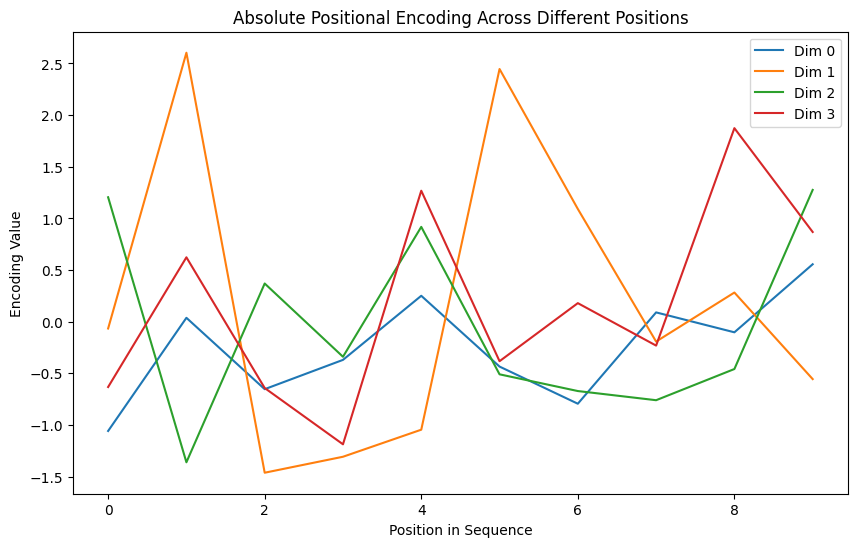

In [6]:
# Instantiate Absolute Positional Encoding
d_model = 16  # Embedding dimension
seq_len = 10  # Sequence length
batch_size = 2  # Number of samples

# Create a dummy input tensor (random embeddings)
input_tensor = torch.randn(batch_size, seq_len, d_model)

# Initialize the Positional Encoding module
pos_encoding = AbsolutePositionalEncoding(d_model)

# Pass the input tensor through the positional encoding
output = pos_encoding(input_tensor)

# Check shape consistency
print("Input Shape:", input_tensor.shape)  # Expected: (2, 10, 16)
print("Output Shape:", output.shape)  # Expected: (2, 10, 16)
# Ensure positional encoding is being added (should be different from input)
print("Output Different from Input:", not torch.allclose(input_tensor, output))

# Extract positional encodings applied to both sequences
pos_enc_1 = output[0] - input_tensor[0]  # Encoding for first batch element
pos_enc_2 = output[1] - input_tensor[1]  # Encoding for second batch element

# Check if positional encodings across different batches are the same
print("Same Positional Encoding for All Batches:", torch.allclose(pos_enc_1, pos_enc_2))

# Create a tensor with zeros to isolate positional encoding effect
zero_tensor = torch.zeros(batch_size, seq_len, d_model)
pos_only_output = pos_encoding(zero_tensor)  # Only positional encoding remains

# Check if different positions have different encodings
pos_variation = torch.all(pos_only_output[:, 0, :] != pos_only_output[:, 1, :])
print("Different Positions Have Different Encodings:", pos_variation)
# Extract encodings for the first position across different batches
pos_0_batch_1 = pos_only_output[0, 0, :]
pos_0_batch_2 = pos_only_output[1, 0, :]

# Check if encoding for position 0 is the same across batches
print("Same Encoding for Same Position Across Batches:", torch.allclose(pos_0_batch_1, pos_0_batch_2))

import matplotlib.pyplot as plt

# Extract encodings for visualization
pos_encoding_values = pos_only_output[0].detach().numpy()  # Take first batch

# Plot the positional encoding for the first few dimensions
plt.figure(figsize=(10, 6))
for i in range(min(4, d_model)):  # Plot first 4 dimensions
    plt.plot(range(seq_len), pos_encoding_values[:, i], label=f'Dim {i}')

plt.xlabel("Position in Sequence")
plt.ylabel("Encoding Value")
plt.title("Absolute Positional Encoding Across Different Positions")
plt.legend()
plt.show()



In [7]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int, prenorm: bool, rpe: bool):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.prenorm = prenorm
        self.attention = MultiHeadAttention(d_model, n_heads, rpe=rpe)
        self.fc_W1 = nn.Parameter(torch.empty((d_model, 4*d_model)))
        self.fc_W2 = nn.Parameter(torch.empty((4*d_model, d_model)))
        self.relu = nn.ReLU()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        nn.init.xavier_normal_(self.fc_W1)
        nn.init.xavier_normal_(self.fc_W2)

    def forward(self, x):
        """
        args:
            x: shape B x N x D
        returns:
            out: shape B x N x D
        START BLOCK
        """
        if self.prenorm:
            attention_input = self.ln1(x)
            attention_output = self.attention(attention_input, attention_input, attention_input)
            x = x + attention_output

            feed_forward_input = self.ln2(x)
            feed_forward_hidden = self.relu(torch.matmul(feed_forward_input, self.fc_W1))
            feed_forward_output = torch.matmul(feed_forward_hidden, self.fc_W2)
            out = x + feed_forward_output
        else:
            attention_output = self.attention(x, x, x)
            x=self.ln1(x+attention_output)

            feed_forward_hidden = self.relu(torch.matmul(x, self.fc_W1))
            feed_forward_output = torch.matmul(feed_forward_hidden, self.fc_W2)
            out = self.ln2(x + feed_forward_output)

        """
        END BLOCK
        """
        return out

In [8]:
class ModelConfig:
    n_layers = 4
    input_dim = 5
    d_model = 256
    n_heads = 4
    prenorm = True
    pos_enc_type = 'ape' # 'ape': Abosolute Pos. Enc., 'rpe': Relative Pos. Enc.
    output_dim = 1 # Binary output: 0: invalid, 1: valid

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            assert hasattr(self, k)
            self.__setattr__(k, v)

class TransformerModel(nn.Module):
    def __init__(self, cfg: ModelConfig):
        super().__init__()
        self.cfg = cfg
        self.enc_W = nn.Parameter(torch.empty((cfg.input_dim, cfg.d_model)))
        if cfg.pos_enc_type == 'ape':
            self.ape = AbsolutePositionalEncoding(d_model=cfg.d_model)
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model=cfg.d_model, n_heads=cfg.n_heads, prenorm=cfg.prenorm, rpe=cfg.pos_enc_type == 'rpe') for _ in range(cfg.n_layers)
        ])
        self.dec_W = nn.Parameter(torch.empty((cfg.d_model, cfg.output_dim)))

        nn.init.xavier_normal_(self.enc_W)
        nn.init.xavier_normal_(self.dec_W)

    def forward(self, x):
        """
        args:
            x: shape B x N x D_in
        returns:
            out: shape B x N x D_out
        START BLOCK
        """
        x=x.type(torch.float32)
        #encoder project the input tokens from d_voc to d_model
        x=torch.matmul(x,self.enc_W)
        #apply the absolution positional encoding
        if self.cfg.pos_enc_type == 'ape':
            x=self.ape(x)
        #apply the transformer layers
        for layer in self.transformer_layers:
            x=layer(x)

        #decoder map each token from d_model to d_out
        out = torch.matmul(x,self.dec_W)
        """
        END BLOCK
        """
        return out

In [9]:
from torch.optim import lr_scheduler

class CustomScheduler(lr_scheduler._LRScheduler):
    def __init__(self, optimizer, total_steps, warmup_steps=1000):
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        super().__init__(optimizer)

    def get_lr(self):
        """
        Compute the custom scheduler with warmup and cooldown
        Hint: self.last_epoch contains the current step number
        START BLOCK
        """
        #mult_factor = 1.0
        current_step = self.last_epoch
        if current_step < self.warmup_steps:
            mult_factor = current_step / self.warmup_steps
        elif current_step <= self.total_steps:
            mult_factor = (self.total_steps-current_step) / (self.total_steps - self.warmup_steps)
        else:
            mult_factor = 0.0

        """
        END BLOCK
        """
        return [group['initial_lr'] * mult_factor for group in self.optimizer.param_groups]

In [10]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class TrainerConfig:
    lr = 0.003
    train_steps = 5000
    batch_size = 256
    evaluate_every = 100
    device = 'cpu'

    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            assert hasattr(self, k)
            self.__setattr__(k, v)

class Trainer:
    def __init__(self, model, cfg: TrainerConfig):
        self.cfg = cfg
        self.device = cfg.device
        self.tokenizer = Tokenizer()
        self.model = model.to(self.device)

    def train(self, train_dataset, val_dataset):
        optimizer = optim.Adam(self.model.parameters(), lr=self.cfg.lr)
        scheduler = CustomScheduler(optimizer, self.cfg.train_steps)
        train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=self.cfg.batch_size)
        for step in range(self.cfg.train_steps):
            self.model.train()
            batch = next(iter(train_dataloader))
            strings, y = batch
            x = self.tokenizer.tokenize_string_batch(strings)

            optimizer.zero_grad()
            loss, _ = self.compute_batch_loss_acc(x, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            if step % self.cfg.evaluate_every == 0:
                val_loss, val_acc = self.evaluate_dataset(val_dataset)
                print(f"Step {step}: Train Loss={loss.item()}, Val Loss: {val_loss}, Val Accuracy: {val_acc}")

    def compute_batch_loss_acc(self, x, y):
        """
        Compute the loss and accuracy of the model on batch (x, y)
        args:
            x: B x N x D_in
            y: B
        return:
            loss, accuracy
        START BLOCK
        """
        #forward pass through the model
        #x: (X,N,D_in) to (B,N,D_out)
        out= self.model(x.to(self.device))
        #extract the output [CLS] token
        #this has dimension of (B,D_out)
        cls_logics = out[:,0,:]
        cls_logics = cls_logics.squeeze(-1) #remove the last dimension

        loss=F.binary_cross_entropy_with_logits(cls_logics,y.float().to(self.device))
        #compute the prediciton labels, the threshold output is at 0.5
        prediction= (torch.sigmoid(cls_logics)>0.5).float()
        #calculate the accuracy by comparing prediciton with groud truth
        acc=torch.mean((prediction==y.to(self.device)).float())

        #loss, acc = torch.tensor([1.0]), torch.tensor([0.0])
        """
        END BLOCK
        """
        return loss, acc

    @torch.no_grad()
    def evaluate_dataset(self, dataset):
        self.model.eval()
        dataloader = DataLoader(dataset, shuffle=False, batch_size=self.cfg.batch_size)
        final_loss, final_acc = 0.0, 0.0
        for batch in dataloader:
            strings, y = batch
            x = self.tokenizer.tokenize_string_batch(strings)
            loss, acc = self.compute_batch_loss_acc(x, y)
            final_loss += loss.item() * x.size(0)
            final_acc += acc.item() * x.size(0)
        return final_loss / len(dataset), final_acc / len(dataset)


In [11]:
"""
In case you were not successful in implementing some of the above classes,
you may reimplement them using pytorch available nn Modules here to receive the marks for part 1.8
If your implementation of the previous parts is correct, leave this block empty.
START BLOCK
"""


"""
END BLOCK
"""
def run_transformer():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = TransformerModel(ModelConfig())
    trainer = Trainer(model, TrainerConfig(device=device))
    parantheses_size=16
    print("Creating datasets.")
    train_dataset = SubstringDataset(seed=1, dataset_size=10_000, str_len=parantheses_size)
    val_dataset = SubstringDataset(seed=2, dataset_size=1_000, str_len=parantheses_size)
    test_dataset = SubstringDataset(seed=3, dataset_size=1_000, str_len=parantheses_size)

    print("Training the model.")
    trainer.train(train_dataset, val_dataset)
    test_loss, test_acc = trainer.evaluate_dataset(test_dataset)
    print(f"Final Test Accuracy={test_acc}, Test Loss={test_loss}")

In [12]:
run_transformer()

Creating datasets.
Training the model.
Step 0: Train Loss=0.7842620611190796, Val Loss: 0.8059312744140625, Val Accuracy: 0.5
Step 100: Train Loss=0.8277391195297241, Val Loss: 0.7811977195739747, Val Accuracy: 0.5
Step 200: Train Loss=0.6946342587471008, Val Loss: 0.7608848166465759, Val Accuracy: 0.5
Step 300: Train Loss=0.7564733028411865, Val Loss: 0.7813116812705994, Val Accuracy: 0.5
Step 400: Train Loss=0.9828035831451416, Val Loss: 0.8041654047966004, Val Accuracy: 0.5
Step 500: Train Loss=0.623783528804779, Val Loss: 0.6439811429977417, Val Accuracy: 0.6349999966621399
Step 600: Train Loss=0.44812142848968506, Val Loss: 0.6221824989318848, Val Accuracy: 0.733
Step 700: Train Loss=0.33700117468833923, Val Loss: 0.38459938621520995, Val Accuracy: 0.8650000047683716
Step 800: Train Loss=0.1679123044013977, Val Loss: 0.17807352364063264, Val Accuracy: 0.9349999971389771
Step 900: Train Loss=0.057962335646152496, Val Loss: 0.13572497165203096, Val Accuracy: 0.9539999971389771
Step 

# Unit Tests

In [13]:
import random
import numpy as np
import torch.optim as optim

def seed_all():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

class TransformerUnitTest:
    def __init__(self, gt_vars: dict, verbose=False):
        self.gt_vars = gt_vars
        self.verbose = verbose

    def test_all(self):
        self.test_tokenizer()
        self.test_ape()
        self.test_mha()
        self.test_transformer_layer()
        self.test_transformer_model()
        self.test_scheduler()
        self.test_loss()

    def test_tokenizer(self):
        seed_all()
        self.check_correctness(
            Tokenizer().tokenize_string('ccpeen', add_cls_token=True),
            self.gt_vars['tokenizer_1'],
            "Tokenization with cls class"
        )
        self.check_correctness(
            Tokenizer().tokenize_string('cpppencpen', add_cls_token=False),
            self.gt_vars['tokenizer_2'],
            "Tokenization without cls class"
        )

    def test_ape(self):
        seed_all()
        ape_result = AbsolutePositionalEncoding(128)(torch.randn((8, 12, 128)))
        self.check_correctness(ape_result, self.gt_vars['ape'], "APE")

    def test_mha(self):
        seed_all()
        mha_result = MultiHeadAttention(d_model=128, n_heads=4, rpe=False)(
            torch.randn((8, 12, 128)), torch.randn((8, 12, 128)), torch.randn((8, 12, 128))
        )
        self.check_correctness(
            mha_result,
            self.gt_vars['mha_no_rpe'],
            "Multi-head Attention without RPE"
        )
        mha_result_rpe = MultiHeadAttention(d_model=128, n_heads=8, rpe=True)(
            torch.randn((8, 12, 128)), torch.randn((8, 12, 128)), torch.randn((8, 12, 128))
        )
        self.check_correctness(
            mha_result_rpe,
            self.gt_vars['mha_with_rpe'],
            "Multi-head Attention with RPE"
        )

    def test_transformer_layer(self):
        seed_all()
        for prenorm in [True, False]:
            transformer_layer_result = TransformerLayer(
                d_model=128, n_heads=4, prenorm=prenorm, rpe=False
            )(torch.randn((8, 12, 128)))
            self.check_correctness(
                transformer_layer_result,
                self.gt_vars[f'transformer_layer_prenorm_{prenorm}'],
                f"Transformer Layer Prenorm {prenorm}"
            )

    def test_transformer_model(self):
        seed_all()
        transformer_model_result = TransformerModel(
            ModelConfig(d_model=128, prenorm=True, pos_enc_type='ape')
        )(torch.randn((8, 12, 5)))
        self.check_correctness(
            transformer_model_result,
            self.gt_vars['transformer_model_result'],
            f"Transformer Model"
        )

    def test_scheduler(self):
        model = TransformerModel(ModelConfig())
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = CustomScheduler(optimizer, 10_000)
        optimizer.step()
        scheduler.step(521)
        self.check_correctness(
            torch.tensor([optimizer.param_groups[0]['lr']]),
            self.gt_vars['scheduler_1'],
            f"Scheduler Warmup"
        )
        scheduler.step(2503)
        self.check_correctness(
            torch.tensor([optimizer.param_groups[0]['lr']]),
            self.gt_vars['scheduler_2'],
            f"Scheduler Cooldown"
        )

    def test_loss(self):
        seed_all()
        model = TransformerModel(ModelConfig())
        trainer = Trainer(model, TrainerConfig(device='cpu'))
        loss_result, _ = trainer.compute_batch_loss_acc(
            torch.randn((8, 12, 5)),
            torch.ones(8).float(),
        )
        self.check_correctness(
            loss_result,
            self.gt_vars['loss'],
            f"Batch Loss"
        )

    def check_correctness(self, out, gt, title):
        try:
            diff = (out - gt).norm()
        except:
            diff = float('inf')
        if diff < 1e-4:
            print(f"[Correct] {title}")
        else:
            print(f"[Wrong] {title}")
            if self.verbose:
                print("-----")
                print("Expected: ")
                print(gt)
                print("Received: ")
                print(out)
                print("-----")


In [ ]:
#!gdown 1-2-__6AALEfqhfew3sJ2QiCE1-rrFMnQ -q -O unit_tests.pkl
import pickle
with open('unit_tests.pkl', 'rb') as f:
    gt_vars = pickle.load(f)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-82e8d7a716a7>", line 3, in <cell line: 0>
    with open('unit_tests.pkl', 'rb') as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: [Errno 107] Transport endpoint is not connected: 'unit_tests.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixe

In [ ]:
TransformerUnitTest(gt_vars, verbose=False).test_all()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-c13027f255eb>", line 1, in <cell line: 0>
    TransformerUnitTest(gt_vars, verbose=False).test_all()
                        ^^^^^^^
NameError: name 'gt_vars' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, n